<a href="https://colab.research.google.com/github/navant/decluttr/blob/main/src/notebooks/decluttr-exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decluttr App using Google's Gemini model+Llama Index+ TrueLens



In [1]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


##  Use Gemini to understand Images from URLs

In [ ]:
# import os

# GOOGLE_API_KEY = ""  # add your GOOGLE API key here
# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path = '/workspaces/decluttr/decluttr-app/backend/.env', override=True)

True

In [3]:
import os

GOOGLE_API_KEY = os.environ['GOOGLE_API_KEY']

In [4]:
# IMAGE_FOLDER_PATH = '/content/drive/MyDrive/Colab Notebooks/Images'
IMAGE_FOLDER_PATH = '/workspaces/decluttr/src/notebooks/images'
image_path_fn = lambda x : f'{IMAGE_FOLDER_PATH}/{x}'

bunch-colored-pencils-handmade-bright-cup-39580701.jpg
kennel.jpg
run thing.jpg
sofa.jpg
toys.jpg


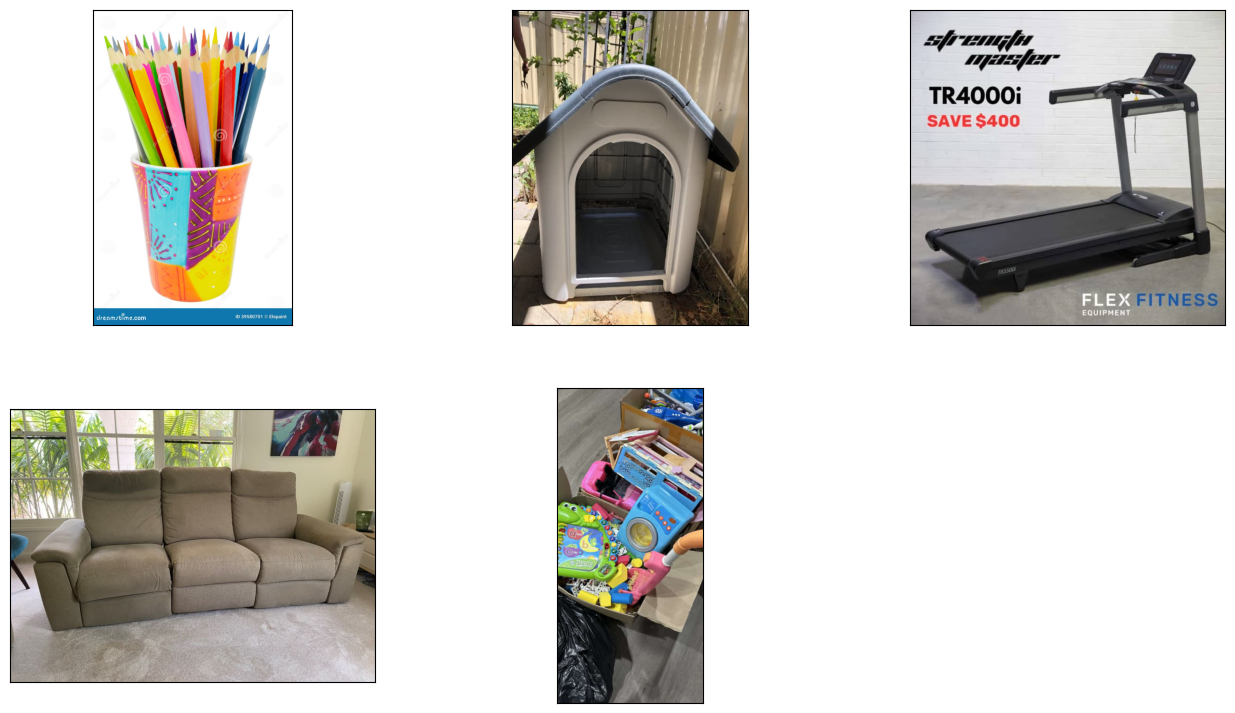

In [5]:
## Plot images

from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir(IMAGE_FOLDER_PATH):
    print(img_path)
    image_paths.append(str(os.path.join(IMAGE_FOLDER_PATH, img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

## Initialize `GeminiMultiModal` and Load Images

In [6]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index import SimpleDirectoryReader


image_documents = SimpleDirectoryReader(IMAGE_FOLDER_PATH).load_data()

gemini_pro = GeminiMultiModal(model="models/gemini-pro")

typing_ext:msg, category, stacklevel, arg : `field_before_validator_function` is deprecated, use `with_info_before_validator_function` instead. <class 'DeprecationWarning'> 1 <function field_before_validator_function at 0x7f53f71e1b20>
typing_ext:msg, category, stacklevel, arg : `general_before_validator_function` is deprecated, use `with_info_before_validator_function` instead. <class 'DeprecationWarning'> 1 <function general_before_validator_function at 0x7f53f71e1c60>
typing_ext:msg, category, stacklevel, arg : `field_after_validator_function` is deprecated, use `with_info_after_validator_function` instead. <class 'DeprecationWarning'> 1 <function field_after_validator_function at 0x7f53f71e1da0>
typing_ext:msg, category, stacklevel, arg : `general_after_validator_function` is deprecated, use `with_info_after_validator_function` instead. <class 'DeprecationWarning'> 1 <function general_after_validator_function at 0x7f53f71e1ee0>
typing_ext:msg, category, stacklevel, arg : `field_wra

/workspaces/decluttr/decluttr-app/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

In [7]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

List available Gemini Models from `google.generativeai`.
Make sure your API key has access to belowing models

In [8]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


### Define the Pydantic Class for the Structured Parser

In [9]:
from pydantic import BaseModel
from typing import List, Literal
from PIL import Image
import matplotlib.pyplot as plt

class Item(BaseModel):
    """Data model for an Item."""

    category: str
    subcategories: List[str]
    title: str
    description: str
    condition: Literal['NEW', 'OLD']  # Restrict to 'NEW' or 'OLD'


### Call the Pydantic Program and Generate Structured Output

In [23]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

# prompt_template_str = """\
#     You are an expert at selling on gumtree people used items.
#     Given an item photo, you will extract the item characteristics as required in a json format.
#     Pay attention to the title that needs to be catchy.
#     Return the answer in the json format as specified. 

#     When formatting a json string, DO NOT INCLUDE special characters or quotes like " or ' INSIDE a text field. 
# """

prompt_template_str = """\
    You are an expert at selling on gumtree people used items.
    Given an item photo, you will extract the item characteristics.
    Pay attention to the title that needs to be catchy.
    Return the answer in the json format as specified. 

    When handling and text field (type "string") ESCAPE any special characters. 
    Example of string field correctly formatted: "description": "This treadmill features a 3.0 CHP motor, a 20\" x 60\" running surface, and a top speed of 12 MPH."
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [24]:

results = []
for img_doc in image_documents:
    
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        Item,
        [img_doc],
        prompt_template_str,
    )
    for r in pydantic_response:
        print(img_doc.image_path, r)
    results.append(pydantic_response)

formatted prompt:     You are an expert at selling on gumtree people used items.
    Given an item photo, you will extract the item characteristics.
    Pay attention to the title that needs to be catchy.
    Return the answer in the json format as specified. 

    When handling and text field (type "string") ESCAPE any special characters. 
    Example of string field correctly formatted: "description": "This treadmill features a 3.0 CHP motor, a 20" x 60" running surface, and a top speed of 12 MPH."



Here's a JSON schema to follow:
{"description": "Data model for an Item.", "properties": {"category": {"title": "Category", "type": "string"}, "subcategories": {"items": {"type": "string"}, "title": "Subcategories", "type": "array"}, "title": {"title": "Title", "type": "string"}, "description": {"title": "Description", "type": "string"}, "condition": {"enum": ["NEW", "OLD"], "title": "Condition", "type": "string"}}, "required": ["category", "subcategories", "title", "description", "cond

`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps`

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [ ]:
from llama_index.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [ ]:
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

For a delightful dining experience, I recommend Mythos Restaurant, known for its American cuisine and unique underwater theme. Overlooking Universal Studios' Inland Sea, this restaurant offers a captivating ambiance. After your meal, explore the nearby tourist attractions such as Universal's Islands of Adventure, Skull Island: Reign of Kong, The Wizarding World of Harry Potter, Jurassic Park River Adventure, and Hollywood Rip Ride Rockit, all located near Mythos Restaurant.
